# Segmentação de Miocárdio por meio de Redes Neurais Convolucionais

Filipe Oliveira

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datapath = 'data'
trainpath = 'NORpatients'
testpath = 'testing'
modelspath = 'models'

batch_size = 16
img_size = (128, 128, 1)
epochs = 25

## Reading dataset and cropping images

In [3]:
from tools.create_df import create

if not os.path.exists(os.path.join(datapath, 'imgs_cropped.pkl')):
    create(datapath, trainpath)

## Partition train and validation

In [4]:
from tools.partition_train_test import get_partitioned_data

cropped_images_filename = 'imgs_cropped.pkl'
cropped_path = os.path.join(datapath, cropped_images_filename)

with open(cropped_path, 'rb') as f:
    df = pickle.load(f)

train, val = get_partitioned_data(df, batch_size)
df = None

['patient061' 'patient062' 'patient063' 'patient064' 'patient065'
 'patient066' 'patient067' 'patient068' 'patient069' 'patient070'
 'patient071' 'patient072' 'patient073' 'patient074' 'patient075'
 'patient076' 'patient077' 'patient078' 'patient079' 'patient080']
['patient064' 'patient077' 'patient067' 'patient071']


## Retrieve the U-Net model

In [5]:
from tools.unet_model import get_model

model = get_model(img_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

## Training the model

In [ ]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy")
model_name = f'model_epochs{epochs}_batchsz{batch_size}_noPatMix'

print("Model: " + model_name)
savepath = os.path.join(modelspath, model_name + '.keras')
model.fit(train, epochs=epochs, validation_data=val)
model.save(savepath)

## Prediction over validation and test sets

Loading test set:

In [6]:
from tools.partition_train_test import get_test_data
batch_size = 1
test = get_test_data(datapath, batch_size)

Reload validation with batch_size = 1

In [7]:
with open(cropped_path, 'rb') as f:
    df = pickle.load(f)

_, val = get_partitioned_data(df, batch_size)
df = None

['patient061' 'patient062' 'patient063' 'patient064' 'patient065'
 'patient066' 'patient067' 'patient068' 'patient069' 'patient070'
 'patient071' 'patient072' 'patient073' 'patient074' 'patient075'
 'patient076' 'patient077' 'patient078' 'patient079' 'patient080']
['patient064' 'patient077' 'patient067' 'patient071']


Predict:

In [8]:
from tensorflow import keras

use_saved_model = True

if use_saved_model:
    modelname = "model_epochs25_batchsz16_noPatMix.keras"
    model_path = os.path.join(modelspath, modelname)
    model = keras.models.load_model(model_path)

preds = {}

preds['val'] = model.predict(val)
preds['test'] = model.predict(test)

204/204 [==============================] - 47s 232ms/step


## Metrics

### Metrics definition:

NRMSE:

In [9]:
def nrmse(true, pred, method='intensity'):
    if method == 'range':
        return rmse(true, pred) / (true.max() - true.min())
    elif method == 'mean':
        return rmse(true, pred) / np.mean(true)
    elif method == 'intensity':
        return np.sqrt(np.power(true - pred, 2) / (np.power(true, 2) + 0.001))
    
def nrmse_mean(trues, preds, method='intensity'):
    nrmses = [nrmse(true, pred, method) for true, pred in zip(trues, preds)]
    return np.mean(nrmses), np.std(nrmses)

SSIM:

In [10]:
from skimage.metrics import structural_similarity as sk_ssim
def ssim(true, pred):
    return sk_ssim(true, pred, channel_axis=-1, data_range=1)

def ssim_mean(trues, preds):
    ssims = [ssim(true, pred) for true, pred in zip(trues, preds)]
    return np.mean(ssims), np.std(ssims)

Dice:

In [11]:
from tools.metrics import threshold_binary_images

def dice(true, pred, threshold=0.2):
    pred = threshold_binary_images(pred, threshold)
    return (2 * np.sum(true[pred == 1]) + 0.001) / (np.sum(true) + np.sum(pred) + 0.001)

def dice_mean(trues, preds, threshold=0.2):
    dices = [dice(true, pred, threshold) for true, pred in zip(trues, preds)]
    return np.mean(dices), np.std(dices), threshold

All metrics above are defined in "tools.metrics" module

### Estimating metrics

The method _metrics.summary_ apply all the metrics above.

Metrics summary for validation patients:

In [12]:
from tools.metrics import summary, dice_threshold

trues = {}

trues['val'] = [val[i][1][0] for i in range(len(val))]
trues['test'] = [test[i][1][0] for i in range(len(test))]

summary(trues['val'], preds['val'], cohort="val")


##### Metrics Summary for validation #####
NRMSE: 0.098 ± 1.172
SSIM: 0.952 ± 0.019
Best Dice: 0.809 ± 0.243 - for threshold 0.250


Finding the best binarization threshold in the validation set and estimating the metrics over the test set using this value:

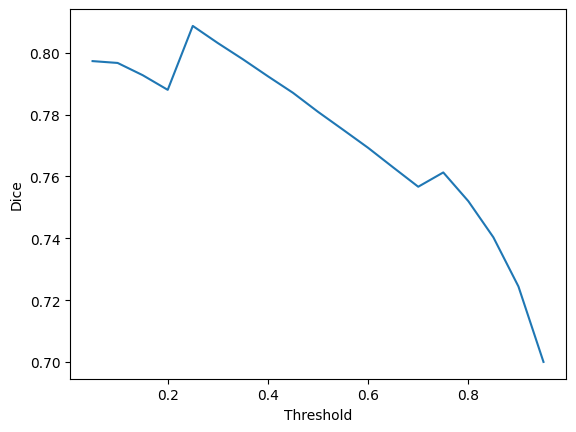


##### Metrics Summary for testing #####
NRMSE: 0.102 ± 1.205
SSIM: 0.949 ± 0.021
Dice: 0.694 ± 0.292 (threshold = 0.25)


In [13]:
_, _, threshold= dice_threshold(trues['val'], preds['val'], plot=True)
summary(trues['test'], preds['test'], cohort="test", threshold=threshold)